<a href="https://colab.research.google.com/github/iship-itb14/Data_Mining_Assignment-2/blob/main/Data_Mining_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

def detect_column_types(df):
    numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
    return numeric_cols, categorical_cols



In [61]:
def numeric_summary(df, numeric_cols):
    summary = df[numeric_cols].describe().T
    summary['IQR'] = summary['75%'] - summary['25%']

    outlier_counts = {}
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
        outlier_counts[col] = outliers.shape[0]

    summary['Outlier Count'] = summary.index.map(outlier_counts)
    return summary


In [62]:
def categorical_summary(df, categorical_cols, top_n=10):
    summaries = {}
    for col in categorical_cols:
        freq = df[col].value_counts(dropna=False).head(top_n)
        pct = df[col].value_counts(normalize=True, dropna=False).head(top_n) * 100
        summaries[col] = pd.DataFrame({'Frequency': freq, 'Percentage': pct})
    return summaries


In [63]:
def plot_basic_eda(df, numeric_cols, categorical_cols, output_dir="output/plots"):
    import os
    os.makedirs(output_dir, exist_ok=True)

    # Histogram (first numeric)
    if numeric_cols:
        plt.figure(figsize=(8,5))
        sns.histplot(df[numeric_cols[0]], bins=30, color='pink')
        plt.title(f'Distribution of {numeric_cols[0]}')
        plt.xlabel(numeric_cols[0])
        plt.savefig(f"{output_dir}/hist_{numeric_cols[0]}.png")

        plt.show()

    # Boxplot (second numeric)
    if len(numeric_cols) > 1:
        plt.figure(figsize=(8,5))
        sns.boxplot(x=df[numeric_cols[1]], color='pink')
        plt.title(f'Boxplot of {numeric_cols[1]}')
        plt.savefig(f"{output_dir}/box_{numeric_cols[1]}.png")

        plt.show()

    # Bar chart (first categorical)
    if categorical_cols:
        top_vals = df[categorical_cols[0]].value_counts().head(10)
        plt.figure(figsize=(10,6))
        sns.barplot(x=top_vals.values, y=top_vals.index, palette='pink')
        plt.title(f'Top categories in {categorical_cols[0]}')
        plt.savefig(f"{output_dir}/bar_{categorical_cols[0]}.png")

        plt.show()

    # Scatter (first two numerics)
    if len(numeric_cols) >= 2:
        plt.figure(figsize=(8,5))
        sns.scatterplot(x=numeric_cols[0], y=numeric_cols[1], data=df,
                        color='hotpink', alpha=0.4)
        plt.title(f'{numeric_cols[0]} vs {numeric_cols[1]}')
        plt.savefig(f"{output_dir}/scatter.png")

        plt.show()

    # Correlation heatmap
    if len(numeric_cols) >= 3:
        plt.figure(figsize=(10,8))
        sns.heatmap(df[numeric_cols].corr(), cmap='RdPu', annot=False)
        plt.title('Correlation Heatmap')
        plt.savefig(f"{output_dir}/correlation_heatmap.png")

        plt.show()


In [64]:
def generate_insights(df, dataset_name="Dataset"):
    print("="*60)
    print(f"KEY INSIGHTS: {dataset_name}")
    print("="*60)

    rows, cols = df.shape
    print(f"• The dataset contains {rows:,} records and {cols} features, indicating a relatively large and rich dataset.")

    # Missing values insight
    missing = df.isnull().sum()
    missing_cols = missing[missing > 0]
    if len(missing_cols) == 0:
        print("• No missing values were observed, suggesting good data completeness.")
    else:
        print("• Missing values are present in the following columns:")
        for col, count in missing_cols.items():
            print(f"  - {col}: {count} missing values")

    # Numerical insights
    num_cols = df.select_dtypes(include=np.number).columns
    if len(num_cols) > 0:
        print("\n• Numerical feature analysis shows:")
        for col in num_cols:
            skew = df[col].skew()
            if skew > 1:
                print(f"  - {col} is heavily right-skewed, indicating presence of outliers or long tails.")
            elif skew < -1:
                print(f"  - {col} is left-skewed.")
            else:
                print(f"  - {col} has a fairly symmetric distribution.")

    # Correlation insights
    if len(num_cols) > 1:
        corr = df[num_cols].corr()
        strong_corr = (
            corr.abs()
            .unstack()
            .sort_values(ascending=False)
            .drop_duplicates()
        )

        strong_corr = strong_corr[strong_corr < 1]

        if len(strong_corr) > 0:
            top_pair = strong_corr.index[0]
            print(f"\n• A strong correlation is observed between '{top_pair[0]}' and '{top_pair[1]}', suggesting potential dependency.")

    # Categorical insights
    cat_cols = df.select_dtypes(include="object").columns
    for col in cat_cols:
        top_val = df[col].value_counts().idxmax()
        perc = df[col].value_counts(normalize=True).max() * 100
        print(f"• '{top_val}' is the most frequent category in '{col}', contributing approximately {perc:.2f}% of the data.")

    print("\n✔ These insights can guide feature selection and hypothesis formulation.")


In [65]:
def generate_limitations(df, dataset_name="Dataset"):
    print("="*60)
    print(f"POTENTIAL LIMITATIONS: {dataset_name}")
    print("="*60)

    print("• The dataset is observational in nature, which limits causal interpretations of relationships.")

    # Class imbalance
    cat_cols = df.select_dtypes(include="object").columns
    for col in cat_cols:
        top_perc = df[col].value_counts(normalize=True).max() * 100
        if top_perc > 50:
            print(f"• The '{col}' feature is highly imbalanced, with one category representing over {top_perc:.2f}% of the data.")

    # Outliers
    num_cols = df.select_dtypes(include=np.number).columns
    for col in num_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        outliers = ((df[col] < q1 - 1.5*iqr) | (df[col] > q3 + 1.5*iqr)).sum()
        if outliers > 0:
            print(f"• The feature '{col}' contains potential outliers ({outliers} detected), which may affect statistical analyses.")

    # Time / metadata issues
    if "date" in " ".join(df.columns).lower():
        print("• Temporal fields may not reflect real-time updates, potentially affecting trend analysis.")

    print("• Some features may rely on external or subjective measurements, introducing noise or bias.")
    print("• Results derived from this dataset may not generalize well beyond the represented population or domain.")

    print("\n✔ These limitations should be acknowledged when interpreting results.")


In [66]:
def run_eda(df, dataset_name="dataset"):
    numeric_cols, categorical_cols = detect_column_types(df)

    num_stats = numeric_summary(df, numeric_cols)
    cat_stats = categorical_summary(df, categorical_cols)

    plot_basic_eda(df, numeric_cols, categorical_cols)

    print(f"\nEDA complete for {dataset_name}")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\nTop Numeric Summary:")
    display(num_stats.head())

    return num_stats, cat_stats


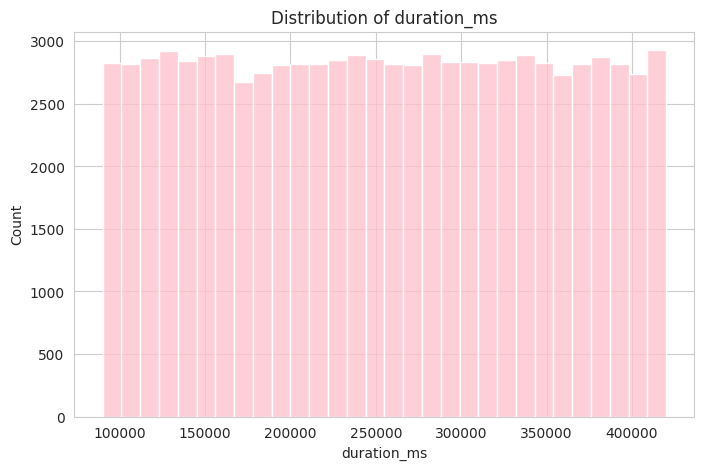

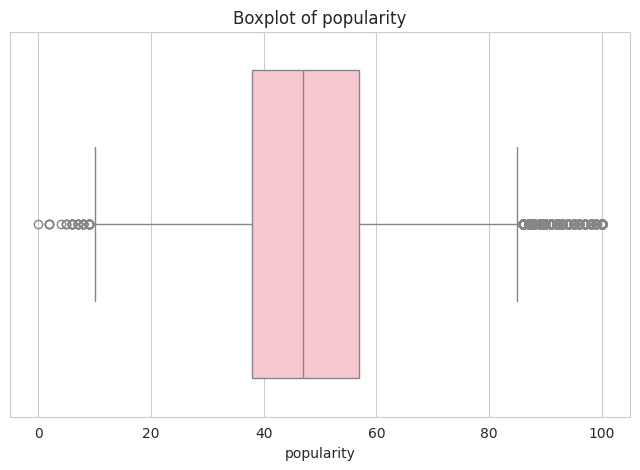

/tmp/ipython-input-1377613048.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vals.values, y=top_vals.index, palette='pink')


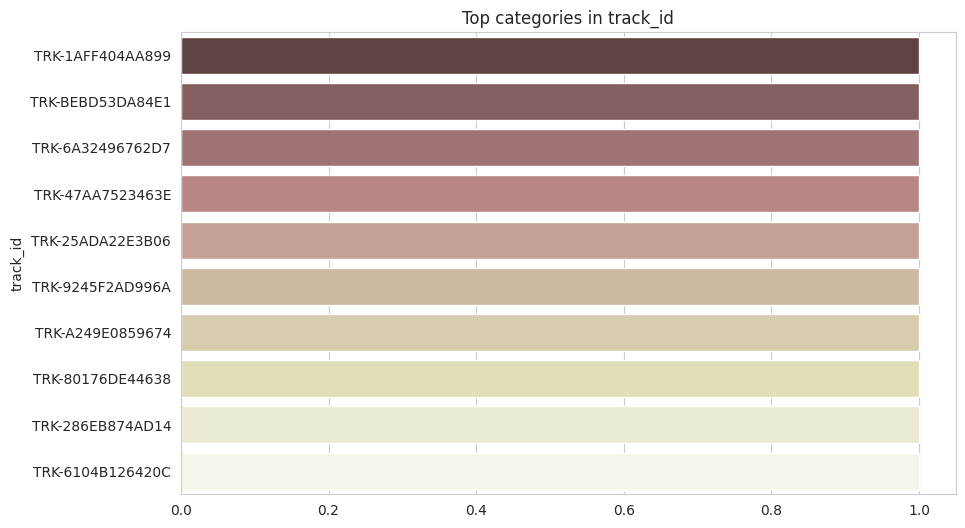

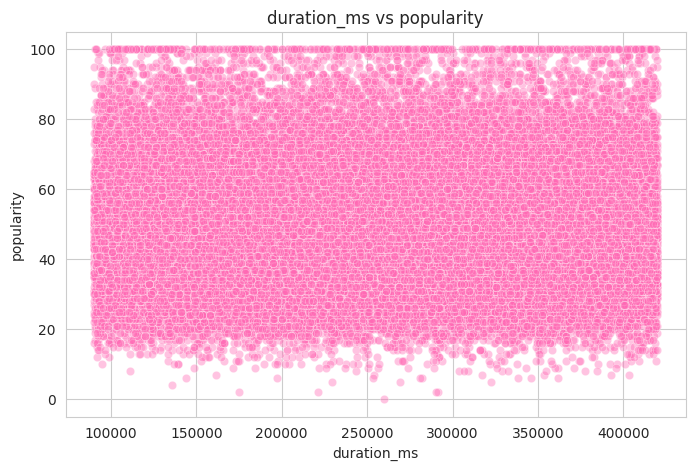

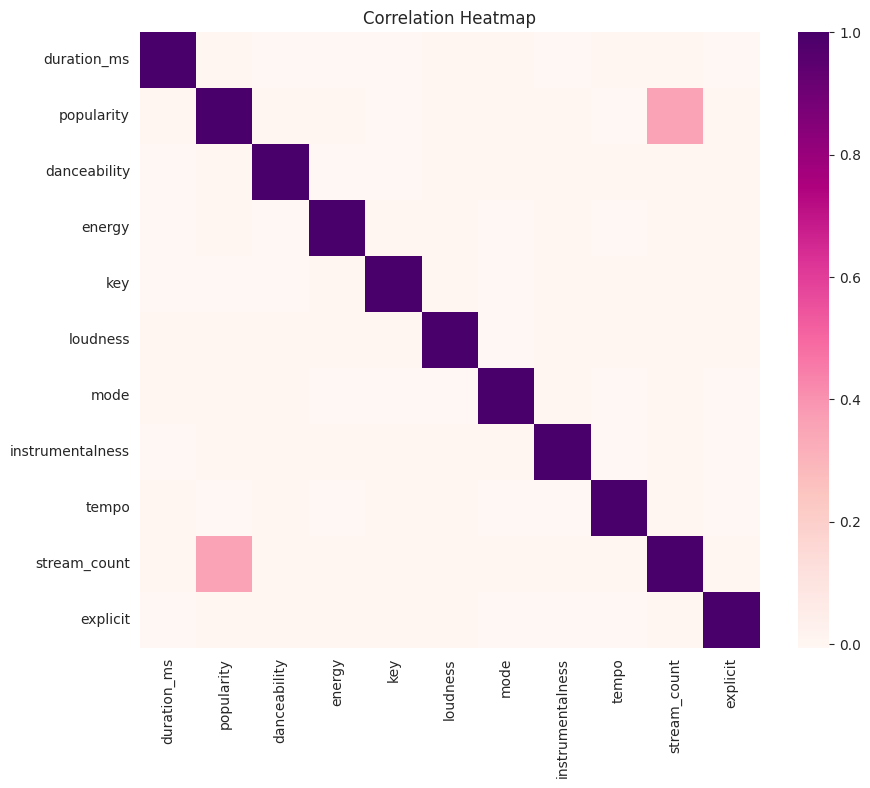


EDA complete for Spotify Dataset
Rows: 85000, Columns: 19

Top Numeric Summary:


,count,mean,std,min,25%,50%,75%,max,IQR,Outlier Count
duration_ms,85000.0,254913.824294,95300.233207,90004.00,171871.50,254920.50,337203.25,420000.00,165331.75,0
popularity,85000.0,48.162894,14.829752,0.00,38.00,47.00,57.00,100.00,19.00,1806
danceability,85000.0,0.520710,0.270799,0.05,0.29,0.52,0.76,0.99,0.47,0
energy,85000.0,0.505412,0.279774,0.02,0.26,0.50,0.75,0.99,0.49,0
key,85000.0,5.515988,3.454069,0.00,2.75,6.00,9.00,11.00,6.25,0


(                    count           mean           std       min         25%  \
 duration_ms       85000.0  254913.824294  9.530023e+04  90004.00  171871.500   
 popularity        85000.0      48.162894  1.482975e+01      0.00      38.000   
 danceability      85000.0       0.520710  2.707991e-01      0.05       0.290   
 energy            85000.0       0.505412  2.797743e-01      0.02       0.260   
 key               85000.0       5.515988  3.454069e+00      0.00       2.750   
 loudness          85000.0     -27.999300  1.559837e+01    -55.00     -41.470   
 mode              85000.0       0.500141  5.000029e-01      0.00       0.000   
 instrumentalness  85000.0       0.399781  2.314697e-01      0.00       0.198   
 tempo             85000.0     129.948351  4.044432e+01     60.00      94.840   
 stream_count      85000.0  214354.682353  1.680637e+06   1000.00    1000.000   
 explicit          85000.0       0.201329  4.009960e-01      0.00       0.000   
 
                          

In [67]:
df1 = pd.read_csv("spotify_2015_2025_85k.csv")
run_eda(df1, "Spotify Dataset")


In [68]:
generate_insights(df, "Spotify Dataset")
generate_limitations(df, "Spotify Dataset")

KEY INSIGHTS: Spotify Dataset
• The dataset contains 10,000 records and 12 features, indicating a relatively large and rich dataset.
• Missing values are present in the following columns:
  - synopsis: 2 missing values
  - start_date: 2 missing values
  - end_date: 84 missing values
  - episodes: 48 missing values

• Numerical feature analysis shows:
  - anime_id has a fairly symmetric distribution.
  - score has a fairly symmetric distribution.
  - rank has a fairly symmetric distribution.
  - popularity has a fairly symmetric distribution.
  - members is heavily right-skewed, indicating presence of outliers or long tails.
  - episodes is heavily right-skewed, indicating presence of outliers or long tails.

• A strong correlation is observed between 'score' and 'rank', suggesting potential dependency.
• 'Ling Jian Zun 4th Season' is the most frequent category in 'title', contributing approximately 0.02% of the data.
• 'No synopsis information has been added to this title. Help improve

In [69]:
df = pd.read_csv("anime.csv")
print(df.shape)
print(df.columns)
print(df.dtypes)
df.head()

(10000, 12)
Index(['anime_id', 'title', 'score', 'rank', 'popularity', 'members',
       'synopsis', 'start_date', 'end_date', 'type', 'episodes', 'image_url'],
      dtype='object')
anime_id        int64
title          object
score         float64
rank            int64
popularity      int64
members         int64
synopsis       object
start_date     object
end_date       object
type           object
episodes      float64
image_url      object
dtype: object


,anime_id,title,score,rank,popularity,members,synopsis,start_date,end_date,type,episodes,image_url
0,28977,Gintama°,9.05,8,347,680037,"Gintoki, Shinpachi, and Kagura return as the f...",2015-01-01,2016-01-01,TV,51.0,https://cdn.myanimelist.net/images/anime/3/720...
1,57555,Chainsaw Man Movie: Reze-hen,9.18,2,962,282129,Sequel to Chainsaw Man .,2025-01-01,2025-01-01,Movie,1.0,https://cdn.myanimelist.net/images/anime/1763/...
2,11061,Hunter x Hunter (2011),9.03,9,8,3107455,Hunters devote themselves to accomplishing haz...,2011-01-01,2014-01-01,TV,148.0,https://cdn.myanimelist.net/images/anime/1337/...
3,52991,Sousou no Frieren,9.29,1,121,1269074,During their decade-long quest to defeat the D...,2023-01-01,2024-01-01,TV,28.0,https://cdn.myanimelist.net/images/anime/1015/...
4,9969,Gintama',9.02,11,406,601940,"After a one-year hiatus, Shinpachi Shimura ret...",2011-01-01,2012-01-01,TV,51.0,https://cdn.myanimelist.net/images/anime/4/503...


In [70]:
# Load second dataset
df_anime = pd.read_csv("anime.csv")

# Date parsing
df_anime['start_date'] = pd.to_datetime(df_anime['start_date'], errors='coerce')
df_anime['end_date'] = pd.to_datetime(df_anime['end_date'], errors='coerce')

# Identifier (exclude from stats conceptually)
identifier_cols = ['anime_id', 'title', 'image_url']


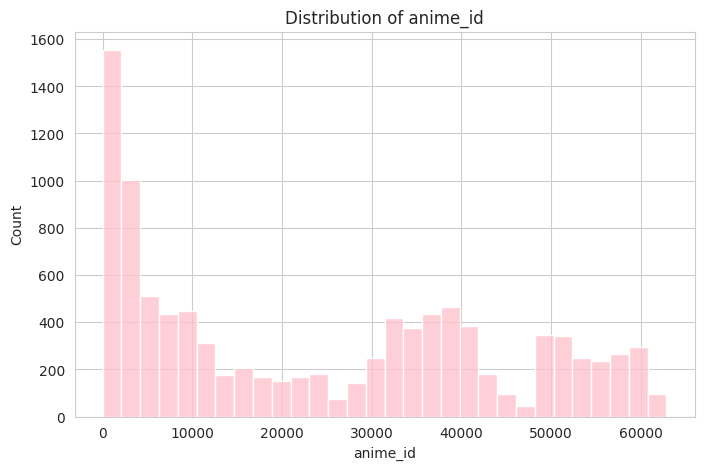

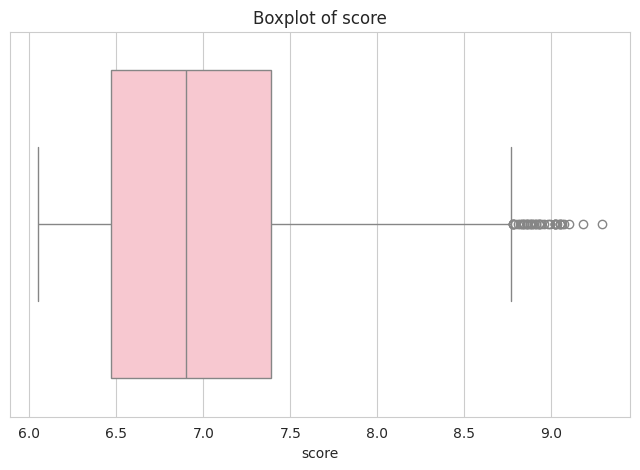

/tmp/ipython-input-1377613048.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vals.values, y=top_vals.index, palette='pink')


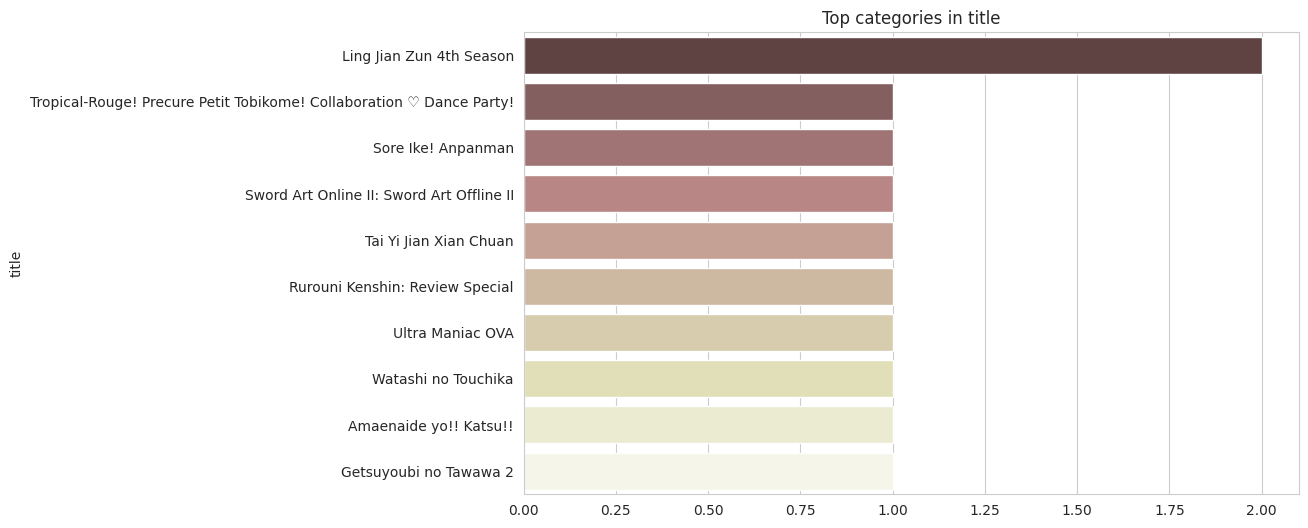

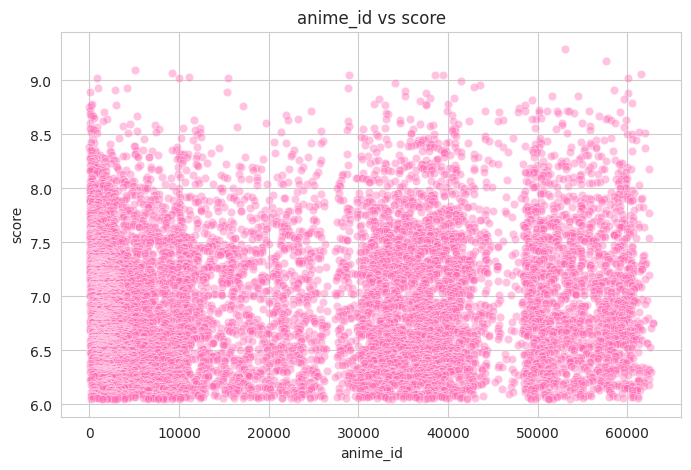

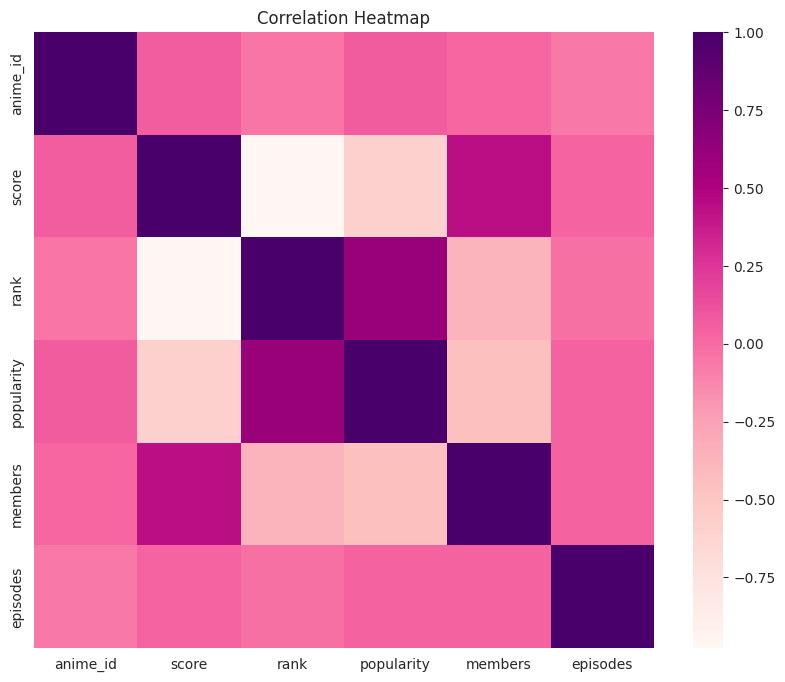


EDA complete for Anime Dataset
Rows: 10000, Columns: 12

Top Numeric Summary:


,count,mean,std,min,25%,50%,75%,max,IQR,Outlier Count
anime_id,10000.0,24129.128000,19948.188153,1.00,4055.50,21406.0,40028.75,62863.00,35973.25,0
score,10000.0,6.980589,0.619406,6.05,6.47,6.9,7.39,9.29,0.92,41
rank,10000.0,5000.494000,2886.898727,1.00,2500.75,5000.5,7500.25,10000.00,4999.50,0
popularity,10000.0,6490.903700,4646.309341,1.00,2591.75,5564.5,9824.25,22184.00,7232.50,14
members,10000.0,107530.875200,273351.351462,226.00,4270.25,18179.0,84692.75,4262220.00,80422.50,1296


(              count           mean            std     min      25%      50%  \
 anime_id    10000.0   24129.128000   19948.188153    1.00  4055.50  21406.0   
 score       10000.0       6.980589       0.619406    6.05     6.47      6.9   
 rank        10000.0    5000.494000    2886.898727    1.00  2500.75   5000.5   
 popularity  10000.0    6490.903700    4646.309341    1.00  2591.75   5564.5   
 members     10000.0  107530.875200  273351.351462  226.00  4270.25  18179.0   
 episodes     9952.0      15.702271      41.865696    1.00     1.00     11.0   
 
                  75%         max       IQR  Outlier Count  
 anime_id    40028.75    62863.00  35973.25              0  
 score           7.39        9.29      0.92             41  
 rank         7500.25    10000.00   4999.50              0  
 popularity   9824.25    22184.00   7232.50             14  
 members     84692.75  4262220.00  80422.50           1296  
 episodes       13.00     1787.00     12.00           1095  ,
 {'title':

In [71]:
run_eda(df_anime, dataset_name="Anime Dataset")


In [73]:
generate_insights(df_anime, "Anime Dataset")
generate_limitations(df_anime, "Anime Dataset")

KEY INSIGHTS: Anime Dataset
• The dataset contains 10,000 records and 12 features, indicating a relatively large and rich dataset.
• Missing values are present in the following columns:
  - synopsis: 2 missing values
  - start_date: 2 missing values
  - end_date: 84 missing values
  - episodes: 48 missing values

• Numerical feature analysis shows:
  - anime_id has a fairly symmetric distribution.
  - score has a fairly symmetric distribution.
  - rank has a fairly symmetric distribution.
  - popularity has a fairly symmetric distribution.
  - members is heavily right-skewed, indicating presence of outliers or long tails.
  - episodes is heavily right-skewed, indicating presence of outliers or long tails.

• A strong correlation is observed between 'score' and 'rank', suggesting potential dependency.
• 'Ling Jian Zun 4th Season' is the most frequent category in 'title', contributing approximately 0.02% of the data.
• 'No synopsis information has been added to this title. Help improve o